# Philippine Languages Clustering

### Setup


In [23]:
%pip install -r requirements.txt

8913.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 9.3 MB/s  0:00:01 eta 0:00:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from rapidfuzz import process, fuzz
import seaborn as sns

This notebook explores the relationships between the different Philippine languages and some foreign languages using different computational techniques to quantify their similarity in language features.

One way to compare language similarity is to compute for the lexical similarity of the words used in the languages. We can compute for the lexical similarity of the 16 languages in our dataset against each other.

## Lexical Similarity


We will use the Levenshtein distance in order to compute the lexical similarity between two languages in our dataset. Levenshtein distance is the measure of the fewest number of single character modification that will transform one word into another (Citation needed).



First we need to transform the tsv file containing the verses of the bible in each of the 16 languages into a word list. 

Load the tsv files into a list.

In [4]:
# Search for .tsv files in the current working directory
tsv_files = list(Path("data/Verses").glob("*.tsv"))

# Check if the list is not empty before printing
if tsv_files:
    print("Printing 3 of the the following .tsv files:")
    for i in range(min(3, len(tsv_files))):
        print(tsv_files[i].name)
else:
    print("No .tsv files found in the current directory.")

Printing 3 of the the following .tsv files:
Bikolano.tsv
Cebuano.tsv
Chavacano.tsv


### Cleaning and Processing the Data

Now that the tsv files are loaded we need to clean the data to remove any non alphabetical characters and lowercase each word. We will create a frequency table alongside the wordlist using a DataFrame.

In [9]:
import re

lang_freq_tables = {}

for path in tqdm(tsv_files, desc="Processing languages"):
    print(f"\n📖 Processing {path}...")

    # Read file and handle missing columns
    df = pd.read_csv(path, sep="\t", dtype=str)
    if "Text" not in df.columns:
        raise ValueError(f"File {path.name} must contain a 'Text' column.")

    counter = Counter()

    # Process line by line
    for verse in df["Text"].dropna():
        # Use regex to extract all words with only letters (including accented), and lowercase them
        words = re.findall(r"[^\W\d_]+", verse.lower(), flags=re.UNICODE)
        counter.update(words)

    # Save as frequency table
    wdf = pd.DataFrame(counter.items(), columns=["word", "count"])
    wdf = wdf.sort_values("count", ascending=False).reset_index(drop=True)

    # Get the language name from the filename
    lang = path.stem

    # Add the language name as a column to the dataframe
    wdf['language'] = lang

    # Add the dataframe to the dictionary with the language name as the key
    lang_freq_tables[lang] = wdf

    print(f"Processed {len(wdf)} unique words for {lang}")

Processing languages:   0%|          | 0/16 [00:00<?, ?it/s]


📖 Processing data/Verses/Bikolano.tsv...


Processing languages:   6%|▋         | 1/16 [00:00<00:04,  3.24it/s]

Processed 17867 unique words for Bikolano

📖 Processing data/Verses/Cebuano.tsv...


Processing languages:  19%|█▉        | 3/16 [00:00<00:02,  4.64it/s]

Processed 17391 unique words for Cebuano

📖 Processing data/Verses/Chavacano.tsv...
Processed 3556 unique words for Chavacano

📖 Processing data/Verses/English.tsv...


Processing languages:  25%|██▌       | 4/16 [00:01<00:03,  3.88it/s]

Processed 13959 unique words for English

📖 Processing data/Verses/Ilokano.tsv...


Processing languages:  31%|███▏      | 5/16 [00:01<00:02,  3.72it/s]

Processed 37256 unique words for Ilokano

📖 Processing data/Verses/Ilonggo.tsv...


Processing languages:  38%|███▊      | 6/16 [00:01<00:02,  3.55it/s]

Processed 19761 unique words for Ilonggo

📖 Processing data/Verses/Ivatan.tsv...
Processed 7992 unique words for Ivatan

📖 Processing data/Verses/Kapampangan.tsv...


Processing languages:  56%|█████▋    | 9/16 [00:02<00:01,  4.89it/s]

Processed 17034 unique words for Kapampangan

📖 Processing data/Verses/Mansaka.tsv...
Processed 8723 unique words for Mansaka

📖 Processing data/Verses/Pangasinan.tsv...


Processing languages:  62%|██████▎   | 10/16 [00:02<00:01,  4.46it/s]

Processed 22497 unique words for Pangasinan

📖 Processing data/Verses/Romblomanon.tsv...
Processed 7226 unique words for Romblomanon

📖 Processing data/Verses/Spanish.tsv...


Processing languages:  75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

Processed 29446 unique words for Spanish

📖 Processing data/Verses/Tagalog.tsv...


Processing languages:  88%|████████▊ | 14/16 [00:03<00:00,  4.57it/s]

Processed 21033 unique words for Tagalog

📖 Processing data/Verses/Tausug.tsv...
Processed 8421 unique words for Tausug

📖 Processing data/Verses/Waray.tsv...


Processing languages: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

Processed 22534 unique words for Waray

📖 Processing data/Verses/Yami.tsv...
Processed 8211 unique words for Yami


One can see that the number of unique words differ from language to language. The languages with the fewest words are those that did not have available translations for many of the chapters in the New Testament.

In [10]:
# Show the number of words for all languages
for lang, df in lang_freq_tables.items():
    print(f"{lang}: {len(df)} words")

Bikolano: 17867 words
Cebuano: 17391 words
Chavacano: 3556 words
English: 13959 words
Ilokano: 37256 words
Ilonggo: 19761 words
Ivatan: 7992 words
Kapampangan: 17034 words
Mansaka: 8723 words
Pangasinan: 22497 words
Romblomanon: 7226 words
Spanish: 29446 words
Tagalog: 21033 words
Tausug: 8421 words
Waray: 22534 words
Yami: 8211 words


### Computing for the Levenshtein Distance

We will compute for the Levenshtein distance for words between two languages. As computing for all the words for each language is too computationally expensive, we will randomly sample a word with a limited sample size. The average Levenshtein distance between two languages will then be the lexical similarity of the two.

In [13]:
langs = list(lang_freq_tables.keys())
wordlists = {lang: lang_freq_tables[lang]["word"].tolist() for lang in langs}

def lexical_similarity(words_a, words_b, sample_size=10000):
    """
    Compute average Levenshtein similarity between two wordlists.
    """
    # Extract the 'word' column from the frequency tables

    # Limit to sample size for performance
    if len(words_a) > sample_size:
        words_a = np.random.choice(words_a, sample_size, replace=False)
    if len(words_b) > sample_size:
        words_b = np.random.choice(words_b, sample_size, replace=False)

    scores = []
    for w in words_a:
        best_match = process.extractOne(w, words_b, scorer=fuzz.ratio)
        if best_match:
            scores.append(best_match[1])
    return np.mean(scores)

def compute_pair(lang_a, lang_b):
    words_a = wordlists[lang_a]
    words_b = wordlists[lang_b]
    sim = lexical_similarity(words_a, words_b)
    return (lang_a, lang_b, sim)

In [14]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import combinations

sim_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)

with ProcessPoolExecutor() as executor:
    futures = {
        executor.submit(compute_pair, lang_a, lang_b): (lang_a, lang_b)
        for lang_a, lang_b in combinations(langs, 2)  # only upper triangle
    }

    for future in tqdm(as_completed(futures), total=len(futures), desc="Computing similarities"):
        lang_a, lang_b, sim = future.result()
        sim_matrix.loc[lang_a, lang_b] = sim
        sim_matrix.loc[lang_b, lang_a] = sim  # mirror for symmetry
        print(f"{lang_a} ↔ {lang_b}: {sim:.2f}%")

# Fill diagonals with 100%
np.fill_diagonal(sim_matrix.values, 100)

Computing similarities:   1%|          | 1/120 [00:02<05:51,  2.95s/it]

Bikolano ↔ Chavacano: 70.80%


Computing similarities:   2%|▏         | 2/120 [00:09<10:30,  5.35s/it]

Bikolano ↔ Romblomanon: 80.01%


Computing similarities:   2%|▎         | 3/120 [00:10<06:10,  3.17s/it]

Bikolano ↔ Ivatan: 76.66%


Computing similarities:   3%|▎         | 4/120 [00:11<04:12,  2.18s/it]

Bikolano ↔ Mansaka: 77.62%


Computing similarities:   4%|▍         | 5/120 [00:13<04:02,  2.11s/it]

Bikolano ↔ Tausug: 75.05%


Computing similarities:   5%|▌         | 6/120 [00:15<03:56,  2.08s/it]

Cebuano ↔ Chavacano: 71.90%


Computing similarities:   6%|▌         | 7/120 [00:19<05:27,  2.90s/it]

Bikolano ↔ Yami: 73.26%


Computing similarities:   7%|▋         | 8/120 [00:58<26:53, 14.41s/it]

Bikolano ↔ Cebuano: 82.40%


Computing similarities:   8%|▊         | 9/120 [00:59<18:42, 10.11s/it]

Bikolano ↔ English: 71.44%


Computing similarities:   8%|▊         | 10/120 [01:01<13:40,  7.46s/it]

Bikolano ↔ Ilokano: 78.21%


Computing similarities:   9%|▉         | 11/120 [01:02<10:21,  5.70s/it]

Bikolano ↔ Kapampangan: 80.09%


Computing similarities:  10%|█         | 12/120 [01:03<07:31,  4.18s/it]

Bikolano ↔ Pangasinan: 79.66%


Computing similarities:  12%|█▏        | 14/120 [01:04<03:55,  2.22s/it]

Bikolano ↔ Ilonggo: 81.57%
Bikolano ↔ Tagalog: 83.07%


Computing similarities:  12%|█▎        | 15/120 [01:05<03:20,  1.91s/it]

Bikolano ↔ Spanish: 70.56%


Computing similarities:  13%|█▎        | 16/120 [01:07<03:33,  2.06s/it]

Cebuano ↔ Ivatan: 75.91%


Computing similarities:  14%|█▍        | 17/120 [01:10<03:42,  2.16s/it]

Cebuano ↔ Mansaka: 78.40%


Computing similarities:  15%|█▌        | 18/120 [01:11<03:19,  1.95s/it]

Cebuano ↔ Romblomanon: 81.67%


Computing similarities:  16%|█▌        | 19/120 [01:12<02:50,  1.68s/it]

Bikolano ↔ Waray: 83.02%


Computing similarities:  17%|█▋        | 20/120 [01:14<02:49,  1.70s/it]

Cebuano ↔ English: 72.09%


Computing similarities:  18%|█▊        | 21/120 [01:15<02:23,  1.45s/it]

Cebuano ↔ Tausug: 76.56%


Computing similarities:  19%|█▉        | 23/120 [01:18<02:18,  1.43s/it]

Cebuano ↔ Ilokano: 78.18%
Chavacano ↔ Ivatan: 77.81%


Computing similarities:  20%|██        | 24/120 [01:19<01:54,  1.20s/it]

Cebuano ↔ Yami: 73.57%


Computing similarities:  21%|██        | 25/120 [01:21<02:30,  1.58s/it]

Chavacano ↔ Mansaka: 75.09%


Computing similarities:  22%|██▏       | 26/120 [01:23<02:18,  1.47s/it]

Cebuano ↔ Ilonggo: 84.73%


Computing similarities:  22%|██▎       | 27/120 [01:24<02:19,  1.50s/it]

Chavacano ↔ Romblomanon: 77.44%


Computing similarities:  23%|██▎       | 28/120 [01:33<05:30,  3.59s/it]

Chavacano ↔ English: 78.83%


Computing similarities:  24%|██▍       | 29/120 [01:36<05:21,  3.54s/it]

Chavacano ↔ Ilokano: 74.37%


Computing similarities:  25%|██▌       | 30/120 [01:36<03:54,  2.61s/it]

Chavacano ↔ Tausug: 66.56%


Computing similarities:  26%|██▌       | 31/120 [01:38<03:18,  2.24s/it]

Chavacano ↔ Ilonggo: 76.74%


Computing similarities:  27%|██▋       | 32/120 [01:40<03:07,  2.13s/it]

Chavacano ↔ Yami: 69.20%


Computing similarities:  28%|██▊       | 33/120 [01:40<02:18,  1.59s/it]

Chavacano ↔ Kapampangan: 77.82%


Computing similarities:  28%|██▊       | 34/120 [01:41<01:54,  1.33s/it]

Chavacano ↔ Pangasinan: 76.02%


Computing similarities:  29%|██▉       | 35/120 [01:44<02:48,  1.98s/it]

Chavacano ↔ Spanish: 85.30%


Computing similarities:  30%|███       | 36/120 [01:46<02:47,  2.00s/it]

Chavacano ↔ Tagalog: 76.27%


Computing similarities:  31%|███       | 37/120 [01:49<03:01,  2.18s/it]

English ↔ Ivatan: 69.79%


Computing similarities:  32%|███▏      | 38/120 [01:54<04:11,  3.07s/it]

English ↔ Mansaka: 67.47%


Computing similarities:  32%|███▎      | 39/120 [01:57<03:53,  2.88s/it]

English ↔ Romblomanon: 69.23%


Computing similarities:  33%|███▎      | 40/120 [01:58<03:12,  2.41s/it]

Chavacano ↔ Waray: 76.46%


Computing similarities:  34%|███▍      | 41/120 [02:02<03:57,  3.00s/it]

Cebuano ↔ Kapampangan: 80.21%


Computing similarities:  35%|███▌      | 42/120 [02:03<03:06,  2.40s/it]

Cebuano ↔ Pangasinan: 79.50%


Computing similarities:  36%|███▌      | 43/120 [02:07<03:37,  2.83s/it]

Cebuano ↔ Tagalog: 82.06%


Computing similarities:  38%|███▊      | 45/120 [02:08<02:05,  1.67s/it]

English ↔ Tausug: 62.62%
Cebuano ↔ Spanish: 70.66%


Computing similarities:  38%|███▊      | 46/120 [02:09<01:33,  1.27s/it]

Cebuano ↔ Waray: 84.56%


Computing similarities:  39%|███▉      | 47/120 [02:13<02:34,  2.12s/it]

English ↔ Yami: 65.69%


Computing similarities:  40%|████      | 48/120 [02:17<03:25,  2.86s/it]

Ilokano ↔ Ivatan: 73.27%


Computing similarities:  41%|████      | 49/120 [02:18<02:46,  2.34s/it]

Ilokano ↔ Mansaka: 73.57%


Computing similarities:  42%|████▏     | 50/120 [02:25<04:19,  3.70s/it]

Ilokano ↔ Romblomanon: 74.36%


Computing similarities:  42%|████▎     | 51/120 [02:41<08:17,  7.22s/it]

English ↔ Ilokano: 69.55%


Computing similarities:  43%|████▎     | 52/120 [02:44<06:40,  5.89s/it]

English ↔ Kapampangan: 73.12%


Computing similarities:  44%|████▍     | 53/120 [02:44<04:45,  4.26s/it]

English ↔ Ilonggo: 71.34%


Computing similarities:  45%|████▌     | 54/120 [02:48<04:34,  4.15s/it]

English ↔ Pangasinan: 71.85%


Computing similarities:  46%|████▌     | 55/120 [02:51<04:00,  3.70s/it]

Ilokano ↔ Tausug: 72.25%


Computing similarities:  47%|████▋     | 56/120 [02:53<03:28,  3.26s/it]

Ilokano ↔ Yami: 71.43%


Computing similarities:  48%|████▊     | 57/120 [02:57<03:45,  3.58s/it]

Ilonggo ↔ Ivatan: 74.79%


Computing similarities:  48%|████▊     | 58/120 [02:58<02:56,  2.84s/it]

English ↔ Spanish: 73.88%


Computing similarities:  49%|████▉     | 59/120 [03:00<02:38,  2.60s/it]

English ↔ Tagalog: 71.76%


Computing similarities:  50%|█████     | 60/120 [03:03<02:31,  2.52s/it]

Ilonggo ↔ Mansaka: 78.12%


Computing similarities:  51%|█████     | 61/120 [03:05<02:25,  2.47s/it]

English ↔ Waray: 71.02%


Computing similarities:  52%|█████▏    | 62/120 [03:06<02:00,  2.08s/it]

Ilonggo ↔ Romblomanon: 82.25%


Computing similarities:  52%|█████▎    | 63/120 [03:12<03:03,  3.23s/it]

Ilokano ↔ Ilonggo: 75.65%


Computing similarities:  53%|█████▎    | 64/120 [03:13<02:16,  2.43s/it]

Ilokano ↔ Kapampangan: 75.38%


Computing similarities:  54%|█████▍    | 65/120 [03:14<01:59,  2.17s/it]

Ilokano ↔ Pangasinan: 76.76%


Computing similarities:  55%|█████▌    | 66/120 [03:16<01:45,  1.95s/it]

Ilonggo ↔ Tausug: 76.99%


Computing similarities:  56%|█████▌    | 67/120 [03:21<02:45,  3.12s/it]

Ilonggo ↔ Yami: 72.60%


Computing similarities:  57%|█████▋    | 68/120 [03:22<02:06,  2.43s/it]

Ivatan ↔ Mansaka: 75.86%
Ilokano ↔ Spanish: 67.52%


Computing similarities:  58%|█████▊    | 70/120 [03:28<02:06,  2.53s/it]

Ivatan ↔ Romblomanon: 76.25%


Computing similarities:  59%|█████▉    | 71/120 [03:29<01:51,  2.28s/it]

Ilokano ↔ Tagalog: 76.39%


Computing similarities:  60%|██████    | 72/120 [03:36<02:47,  3.50s/it]

Ivatan ↔ Tausug: 71.75%


Computing similarities:  61%|██████    | 73/120 [03:43<03:25,  4.38s/it]

Ivatan ↔ Yami: 79.16%


Computing similarities:  62%|██████▏   | 74/120 [03:47<03:20,  4.35s/it]

Ilokano ↔ Waray: 76.22%


Computing similarities:  62%|██████▎   | 75/120 [03:53<03:29,  4.66s/it]

Kapampangan ↔ Mansaka: 77.54%


Computing similarities:  63%|██████▎   | 76/120 [03:54<02:47,  3.81s/it]

Ilonggo ↔ Kapampangan: 79.44%


Computing similarities:  64%|██████▍   | 77/120 [03:58<02:45,  3.84s/it]

Ilonggo ↔ Pangasinan: 78.78%


Computing similarities:  65%|██████▌   | 78/120 [04:01<02:32,  3.64s/it]

Kapampangan ↔ Romblomanon: 77.57%


Computing similarities:  66%|██████▌   | 79/120 [04:03<02:05,  3.05s/it]

Ilonggo ↔ Spanish: 69.46%


Computing similarities:  67%|██████▋   | 80/120 [04:05<01:46,  2.67s/it]

Ivatan ↔ Kapampangan: 76.17%


Computing similarities:  68%|██████▊   | 81/120 [04:06<01:26,  2.22s/it]

Ilonggo ↔ Tagalog: 81.55%


Computing similarities:  68%|██████▊   | 82/120 [04:06<01:04,  1.70s/it]

Ivatan ↔ Pangasinan: 77.23%


Computing similarities:  69%|██████▉   | 83/120 [04:07<00:54,  1.47s/it]

Ilonggo ↔ Waray: 83.40%


Computing similarities:  70%|███████   | 84/120 [04:12<01:31,  2.53s/it]

Kapampangan ↔ Tausug: 76.84%


Computing similarities:  71%|███████   | 85/120 [04:13<01:06,  1.90s/it]

Ivatan ↔ Tagalog: 76.38%


Computing similarities:  72%|███████▎  | 87/120 [04:14<00:36,  1.11s/it]

Mansaka ↔ Romblomanon: 78.51%
Ivatan ↔ Spanish: 69.56%


Computing similarities:  73%|███████▎  | 88/120 [04:15<00:35,  1.11s/it]

Kapampangan ↔ Yami: 73.50%


Computing similarities:  74%|███████▍  | 89/120 [04:20<01:11,  2.30s/it]

Ivatan ↔ Waray: 76.36%


Computing similarities:  75%|███████▌  | 90/120 [04:22<01:10,  2.35s/it]

Mansaka ↔ Yami: 75.32%


Computing similarities:  76%|███████▌  | 91/120 [04:23<00:52,  1.82s/it]

Pangasinan ↔ Romblomanon: 75.81%


Computing similarities:  77%|███████▋  | 92/120 [04:23<00:39,  1.42s/it]

Mansaka ↔ Tausug: 76.88%


Computing similarities:  78%|███████▊  | 93/120 [04:34<01:51,  4.13s/it]

Pangasinan ↔ Tausug: 73.50%


Computing similarities:  78%|███████▊  | 94/120 [04:43<02:27,  5.68s/it]

Pangasinan ↔ Yami: 74.58%


Computing similarities:  79%|███████▉  | 95/120 [04:51<02:39,  6.37s/it]

Kapampangan ↔ Pangasinan: 80.37%


Computing similarities:  80%|████████  | 96/120 [05:00<02:48,  7.03s/it]

Kapampangan ↔ Spanish: 71.57%


Computing similarities:  81%|████████  | 97/120 [05:01<02:03,  5.35s/it]

Kapampangan ↔ Tagalog: 81.89%


Computing similarities:  82%|████████▏ | 98/120 [05:05<01:46,  4.82s/it]

Mansaka ↔ Pangasinan: 77.66%


Computing similarities:  82%|████████▎ | 99/120 [05:06<01:17,  3.70s/it]

Mansaka ↔ Spanish: 69.37%


Computing similarities:  83%|████████▎ | 100/120 [05:07<00:59,  2.99s/it]

Romblomanon ↔ Tausug: 77.29%


Computing similarities:  84%|████████▍ | 101/120 [05:10<00:57,  3.01s/it]

Kapampangan ↔ Waray: 79.22%


Computing similarities:  85%|████████▌ | 102/120 [05:11<00:45,  2.53s/it]

Mansaka ↔ Tagalog: 78.47%


Computing similarities:  86%|████████▌ | 103/120 [05:12<00:32,  1.94s/it]

Mansaka ↔ Waray: 79.57%
Romblomanon ↔ Yami: 72.49%


Computing similarities:  88%|████████▊ | 105/120 [05:18<00:35,  2.38s/it]

Spanish ↔ Tausug: 61.08%


Computing similarities:  88%|████████▊ | 106/120 [05:22<00:37,  2.71s/it]

Spanish ↔ Yami: 64.65%


Computing similarities:  89%|████████▉ | 107/120 [05:23<00:31,  2.40s/it]

Tagalog ↔ Tausug: 76.91%


Computing similarities:  90%|█████████ | 108/120 [05:25<00:26,  2.17s/it]

Pangasinan ↔ Spanish: 70.27%


Computing similarities:  91%|█████████ | 109/120 [05:28<00:26,  2.42s/it]

Pangasinan ↔ Tagalog: 79.07%


Computing similarities:  92%|█████████▏| 110/120 [05:29<00:20,  2.07s/it]

Tagalog ↔ Yami: 73.45%


Computing similarities:  92%|█████████▎| 111/120 [05:30<00:16,  1.83s/it]

Pangasinan ↔ Waray: 78.10%


Computing similarities:  93%|█████████▎| 112/120 [05:31<00:12,  1.60s/it]

Tausug ↔ Yami: 70.82%


Computing similarities:  94%|█████████▍| 113/120 [05:33<00:11,  1.60s/it]

Romblomanon ↔ Spanish: 69.08%


Computing similarities:  95%|█████████▌| 114/120 [05:33<00:08,  1.34s/it]

Waray ↔ Yami: 72.17%


Computing similarities:  96%|█████████▌| 115/120 [05:36<00:08,  1.79s/it]

Romblomanon ↔ Tagalog: 81.07%


Computing similarities:  97%|█████████▋| 116/120 [05:40<00:09,  2.49s/it]

Romblomanon ↔ Waray: 83.25%


Computing similarities:  98%|█████████▊| 117/120 [05:51<00:14,  4.75s/it]

Spanish ↔ Tagalog: 69.47%


Computing similarities:  98%|█████████▊| 118/120 [05:52<00:07,  3.68s/it]

Spanish ↔ Waray: 69.98%


Computing similarities: 100%|██████████| 120/120 [05:53<00:00,  2.94s/it]

Tagalog ↔ Waray: 81.74%
Tausug ↔ Waray: 77.50%


### Results

Though this does not have a high accuracy for the computed scores in the similarity matrix because it is only a sample of each languages, it can give a general idea on the lexical similarity between each of the languages. For this, we used 10000 words per language, though some languages have less than that. Sampling the words and having an unequal wordlist introduces large biases in the result. Thus we can only use the computed data for surface level comparison.

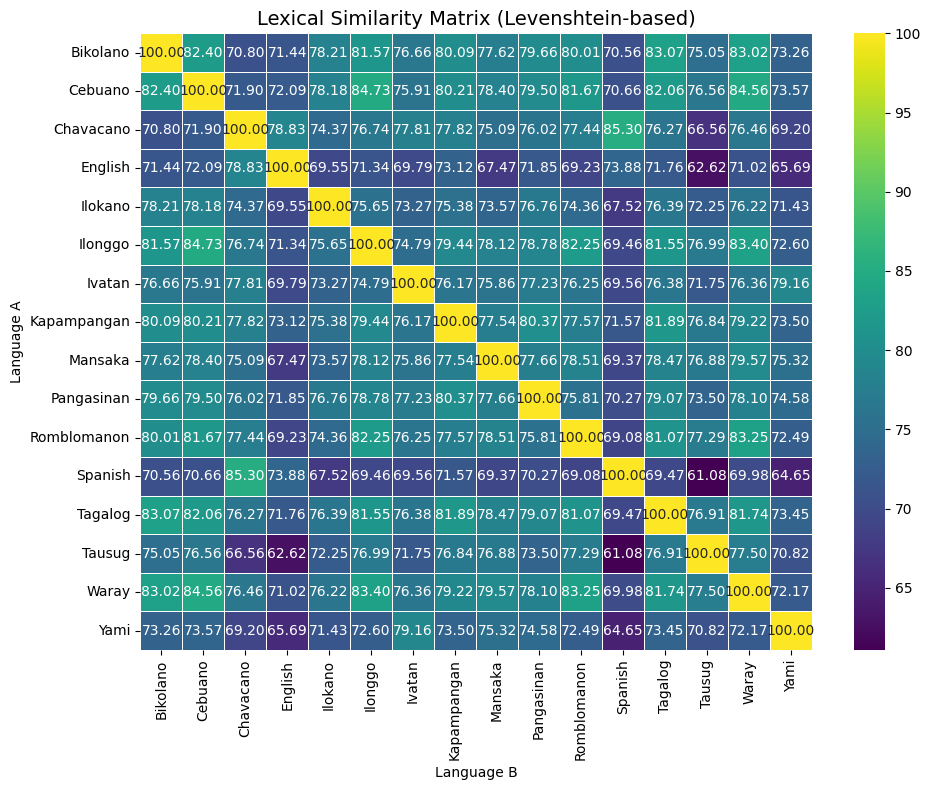

In [ ]:

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title("Lexical Similarity Matrix (Levenshtein-based)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

We can see that languages in the Philippines have a much higher lexical similarity than the foreign languages, specifically English and Spanish. This is reflected where the heatmap forms a cross shape where Spanish and English has a lower similarity measure towards the Philippine Languages, though there are exceptions. And the Austronesian adjacent language Yami has a similarity measure near that of other Philippine Languages. While Chavacano has a very high similarity measure to Spanish, reflecting its origins as a  Spanish-based creole language.

Now that we have computed for the similarity matrix between the 16 languages, we can plot the result using a dendogram to be able to more easily distinguish the hierarchy of which languages are more similar to each other.

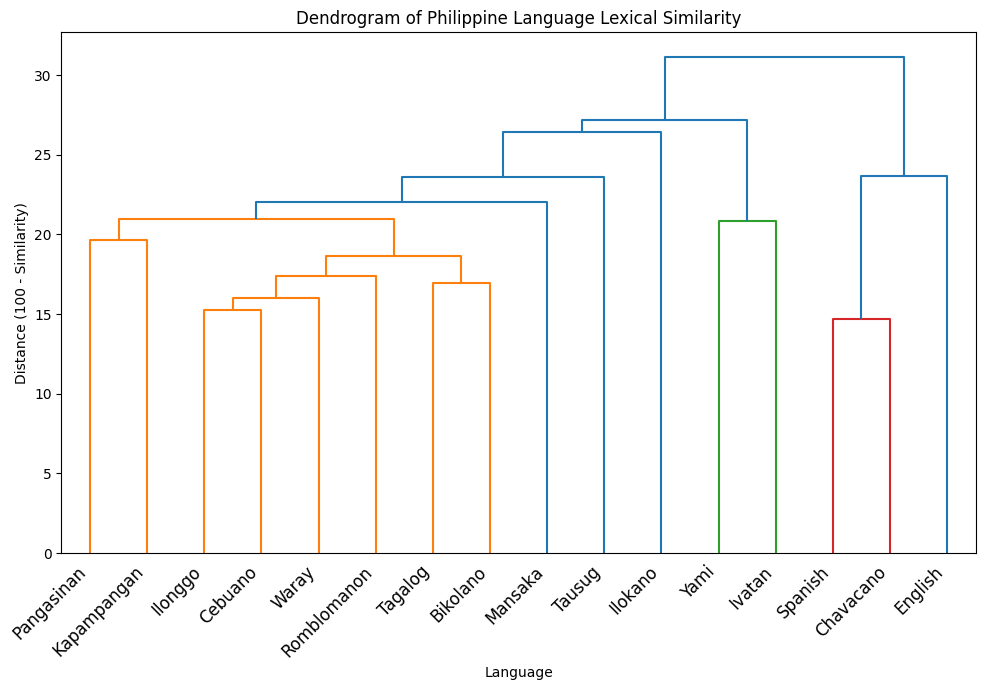

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix = 100 - sim_matrix

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix = squareform(distance_matrix)

linked = linkage(condensed_distance_matrix, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=langs,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Philippine Language Lexical Similarity')
plt.xlabel('Language')
plt.ylabel('Distance (100 - Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Token-level Distributional Similarity

To account for the weaknesses of Levenshtein distance as a measure for the lexical similarity, let us compute for another similarity measure. This time we will calculate the token-based distribution of the n-grams for the corpus of verses in dataset.

### Data Preprocessing

Let us merge all the verses of each languages into a single string file.

In [38]:
def load_corpus(filename, text_column="Text"):
    df = pd.read_csv(filename, sep="\t", dtype=str)
    if text_column not in df.columns:
        raise ValueError(f"File {filename} must contain a '{text_column}' column.")
    text_list = df[text_column].dropna().tolist()
    
    #
    cleaned_text = " ".join([re.sub(r"[^\w\s]", "", text, flags=re.UNICODE).lower() for text in text_list])
    return cleaned_text

In [39]:
corpus = []
labels = []
for file in tsv_files:
    lang_corpus = load_corpus(file)
    
    if lang_corpus:
        corpus.append(lang_corpus)
        labels.append(file.stem)
        
print(labels)

['Bikolano', 'Cebuano', 'Chavacano', 'English', 'Ilokano', 'Ilonggo', 'Ivatan', 'Kapampangan', 'Mansaka', 'Pangasinan', 'Romblomanon', 'Spanish', 'Tagalog', 'Tausug', 'Waray', 'Yami']


### N-Gram

For this project we will use Trigrams in order to compute for the token similarity distribution. This will be able to capture the unique structure (eg: suffix, prefix) of the word and be long enough to have a distinctive pattern as oppose to bigrams (Citation needed)[Expand more?]. 

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
vectors = vectorizer.fit_transform(corpus)
cosine_sim_matrix = cosine_similarity(vectors)

### Result

We can see a similar cross shape pattern of the heatmap where the Foreign languages have lower similarity measure against the Philippine Languages. Though the overall scores have become widely more distributed as compared to Levenshtein Distance.

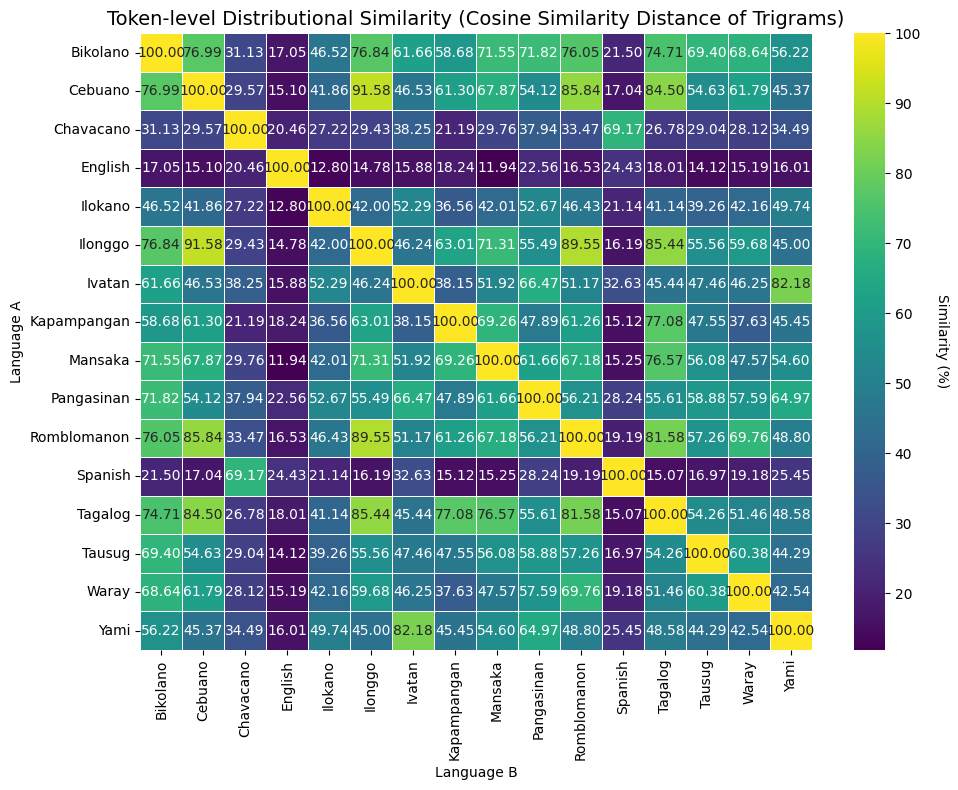

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix * 100, annot=True, cmap="viridis", fmt=".2f", linewidths=.5, xticklabels=labels, yticklabels=labels)
plt.title("Token-level Distributional Similarity (Cosine Similarity Distance of Trigrams)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
cbar = plt.gca().collections[0].colorbar
cbar.set_label("Similarity (%)", rotation=270, labelpad=20)
plt.tight_layout()
plt.show()

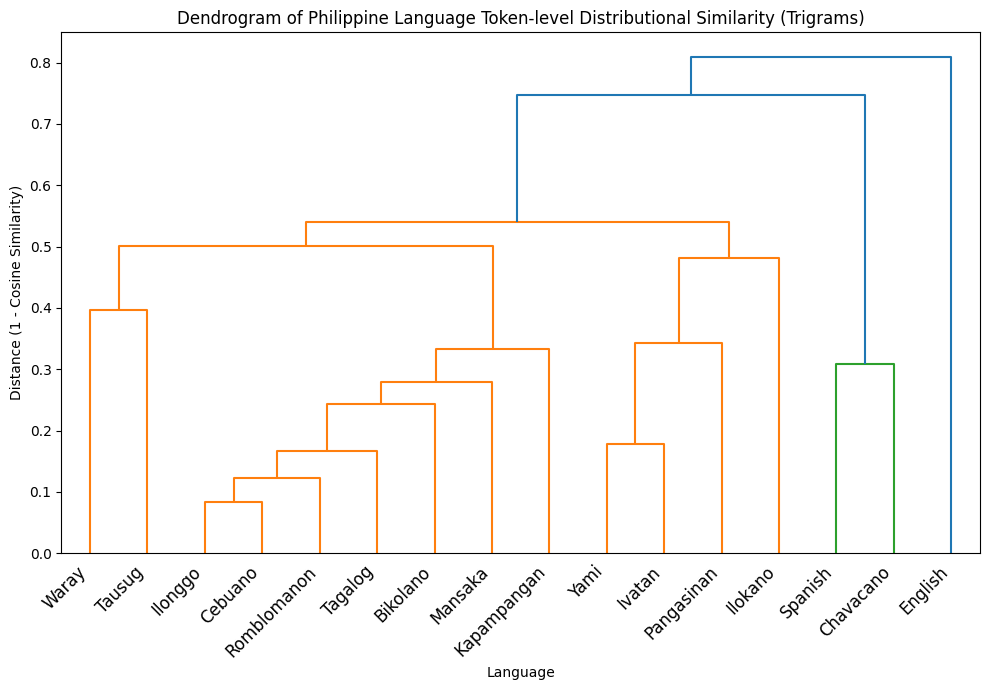

In [42]:
# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix_cosine = 1 - cosine_sim_matrix

# Ensure diagonal is zero
np.fill_diagonal(distance_matrix_cosine, 0)

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix_cosine = squareform(distance_matrix_cosine)

linked_cosine = linkage(condensed_distance_matrix_cosine, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked_cosine,
           orientation='top',
           labels=labels,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Philippine Language Token-level Distributional Similarity (Trigrams)')
plt.xlabel('Language')
plt.ylabel('Distance (1 - Cosine Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Many of the results from the Lexical Similarity Dendogram still appear here. Yami and Ivatan, Spanish and Chavacano, and Ilonggo and Cebuano still cluster closes to each other. Though Waray and Tausug clustered much more closely using this measure. Another thing that changed is that the clustering of the Philippine Languages became more detailed based on their Token Distribution similarity.